In [33]:
import numpy as np
import h5py
import yaml
import os
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.style.use('dark_background')


In [68]:
run_duration = 360
outro_duration, intro_duration = 16, 16
trial_duration = 4
total_n_trials = int(run_duration / trial_duration)
n_empty_trials = 10
print(total_n_trials)

90


In [66]:
def create_train_order(total_n_trials=90, 
                        n_empty_trials=10, 
                        n_ori_distribution_blocks=4,
                        empty_trial_slack=2):
    """
    Returns a list of trial orientations, one for each trial.
    """
    basic_orientations = np.linspace(0, np.pi, total_n_trials-n_empty_trials, endpoint=False)
    orientations = np.zeros(total_n_trials)

    empty_stride_f = total_n_trials/(n_empty_trials+1)
    empty_trials = np.cumsum(np.ones(n_empty_trials)*empty_stride_f).astype(int)
    empty_trials += np.random.randint(-2,2,size=len(empty_trials))

    random_orientations = np.array([np.random.permutation(a) 
                                    for a in [basic_orientations[i::n_ori_distribution_blocks] 
                                                        for i in range(n_ori_distribution_blocks)]]).ravel()
    # print(random_orientations)
    skip = 0
    for i in range(len(orientations)):
        if i in empty_trials:
            orientations[i] = np.nan
            skip += 1
        else:
            orientations[i] = random_orientations[i-skip]

    return orientations

[0.         0.03926991 0.07853982 0.11780972 0.15707963 0.19634954
 0.23561945 0.27488936 0.31415927 0.35342917 0.39269908 0.43196899
 0.4712389  0.51050881 0.54977871 0.58904862 0.62831853 0.66758844
 0.70685835 0.74612826 0.78539816 0.82466807 0.86393798 0.90320789
 0.9424778  0.9817477  1.02101761 1.06028752 1.09955743 1.13882734
 1.17809725 1.21736715 1.25663706 1.29590697 1.33517688 1.37444679
 1.41371669 1.4529866  1.49225651 1.53152642 1.57079633 1.61006623
 1.64933614 1.68860605 1.72787596 1.76714587 1.80641578 1.84568568
 1.88495559 1.9242255  1.96349541 2.00276532 2.04203522 2.08130513
 2.12057504 2.15984495 2.19911486 2.23838477 2.27765467 2.31692458
 2.35619449 2.3954644  2.43473431 2.47400421 2.51327412 2.55254403
 2.59181394 2.63108385 2.67035376 2.70962366 2.74889357 2.78816348
 2.82743339 2.8667033  2.9059732  2.94524311 2.98451302 3.02378293
 3.06305284 3.10232275]


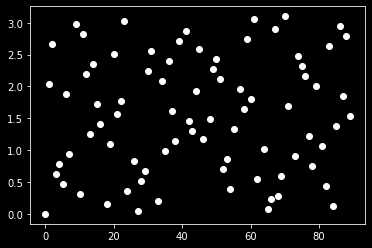

In [69]:
plt.plot(create_train_order(), 'wo')

(0.0, 3.141592653589793)

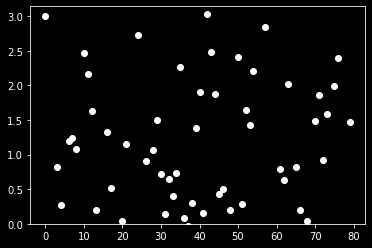

In [54]:
plt.plot(np.random.vonmises(np.pi/4, 0.5, total_n_trials-n_empty_trials), 'wo')
plt.ylim([0,np.pi])

array([-1, -1,  0, -2,  1,  1,  0,  2,  1, -1])